Il codice nella cella seguente **deve essere eseguito**, ma **non deve essere modificato**, perché essenziale per un'esecuzione senza errori del successivo codice del laboratorio. Dopo averlo eseguito, attendi che scompaia il simbolo [*] o che il pallino adiacente ad R in alto a destra diventi bianco

In [1]:
#Esegui ma non modificare. Attendi qualche secondo che scompaia il simbolo [*] 
#o che il pallino adiacente ad R in alto a destra diventi bianco
#potrebbe essere necessario qualche minuto
source('lib/preamble.R')
default=options()

# Introduzione

L'obiettivo dei modelli lineari è quello di definire una relazione lineare tra una variabile dipendente (o di risposta) ed un insieme di variabili indipendenti,  dette anche *covariate* o *predittori*.
Sperando di migliorare la relazione lineare e le previsioni della variabile di risposta, potresti tuttavia essere tentato di includere nel modello tutte le covariate a disposizione. In realtà, ciò potrebbe comportare diversi inconvenienti. Due di essi sono il problema della *multicollinearità* dei predittori e dell'adattamento eccessivo ai dati o *overfitting*. Attraverso gli  esempi riportati di seguito, cerco di farti intuire da dove nascono tali problemi.

## Multicollinearità
Provo a farti intuire il problema della multicollinearità partendo da un data set simulato.
Generiamo $n=100$ osservazioni di due predittori indipendenti `x1` e `x2` da una distribuzione normale. 

Immaginiamo di conoscere i coefficienti 
$\beta_0=1$, $\beta_1=2$ e $\beta_2= 3$ per generare la variabile dipendente 
$$y=\beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \varepsilon$$
con $\varepsilon$ simulato da una distribuzione normale (di media nulla) e `sd=0.6`.
Registriamo quindi tutte le osservazioni delle variabili simulate, `y`, `x1`e `x2`, come colonne del data frame `df`.

In [2]:
#Simuliamo il data set
n <- 100
beta1 <- 2
beta0 <- 1
beta2 <- 3
set.seed(123)
x1 <- rnorm(n)
x2 <- rnorm(n, mean = 1, sd = 2)
eps <- rnorm(n, sd = 0.6)
y <- beta0 + beta1 * x1 + beta2 * x2 + eps
df <- data.frame(y, x1, x2)

Quindi, sulla base di questi dati simulati, stimiamo un modello interpretativo di regressione lineare multipla che interpreti la variabile di risposta $y$, attraverso `x1` ed `x2`.

In [3]:
mod <- lm(y ~ ., df)   
X <- model.matrix(mod)
summary(mod) 


Call:
lm(formula = y ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.12381 -0.39645 -0.07467  0.37281  1.24790 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.07390    0.06202   17.32   <2e-16 ***
x1           1.92010    0.06292   30.52   <2e-16 ***
x2           3.00714    0.02970  101.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5708 on 97 degrees of freedom
Multiple R-squared:  0.9912,	Adjusted R-squared:  0.991 
F-statistic:  5452 on 2 and 97 DF,  p-value: < 2.2e-16


Adesso, generiamo una terza variabile `x3`, fortemente correlata ad `x2`. In pratica, `x3` è identica ad `x2`, ma con l'aggiunta di un errore sperimentale normale (di media nulla) e deviazione standard pari a `sd=0.01`. Situazioni di questo tipo possono accadere nella pratica quando la stessa grandezza, per esempio, viene registrata da due sensori indipendenti. 

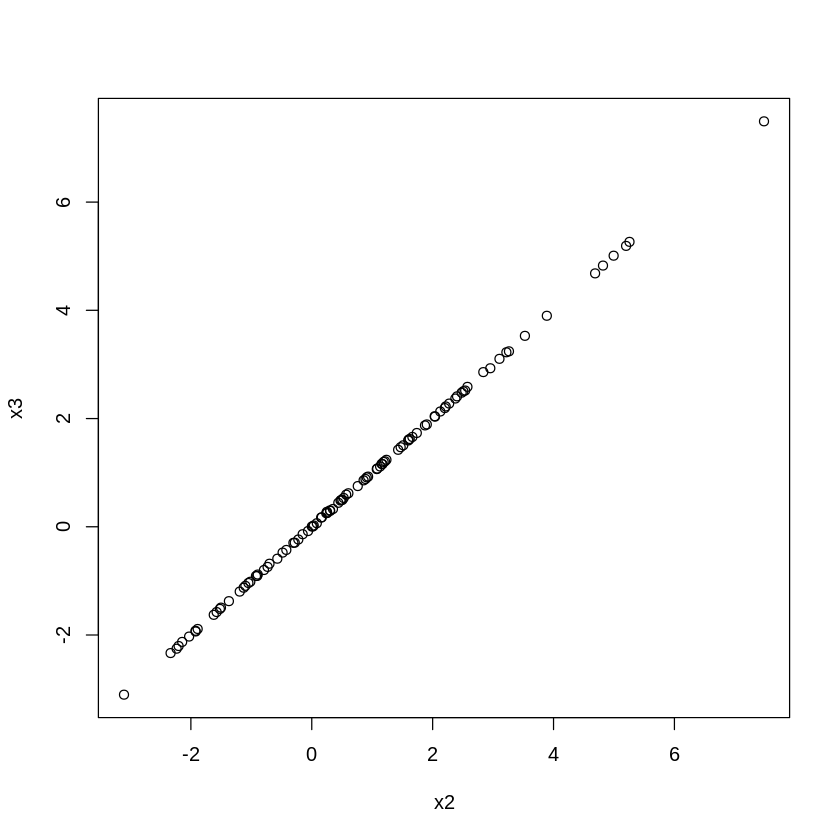

In [4]:
x3 <- x2 + rnorm(n, sd = 0.01)
plot(x2, x3)

Aggiungiamo quindi le osservazioni simulate di `x3` come ulteriore colonna del data frame `df` e immaginiamo di voler inserire `x3` nel modello di regressione multipla, per tentare di spiegare "meglio" la variabile dipendente $y$.

In [5]:
df <- data.frame(y,x1,x2,x3)

mod <- lm(y ~ ., df)   
X <- model.matrix(mod)
summary(mod)           
#nota l'elevata deviazione standard delle stime!
#i p-value dicono che le variabili non sono significative!
#anche se sono state simulate da un modello!


Call:
lm(formula = y ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.14920 -0.39388 -0.09137  0.38386  1.23819 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.07249    0.06232  17.209   <2e-16 ***
x1           1.91874    0.06322  30.351   <2e-16 ***
x2           5.84758    5.55508   1.053    0.295    
x3          -2.83980    5.55376  -0.511    0.610    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.573 on 96 degrees of freedom
Multiple R-squared:  0.9912,	Adjusted R-squared:  0.9909 
F-statistic:  3607 on 3 and 96 DF,  p-value: < 2.2e-16


Anche in questo semplice caso, in cui non è in discussione la struttura del modello, che è lineare per ipotesi e costruzione, gli `Std.Error` degli stimatori dei coefficienti di regressione di `x2` e `x3` sono artificialmente elevati. Ciò si ripercuote sull'ampiezza degli intervalli di confidenza dei parametri (coefficienti di regressione) e quindi sulla fiducia che possiamo riporre nelle stime $\hat \beta_2$ e $\hat \beta_3$.
In altre parole, piccole variazioni dei dati di ingresso (covariate) si trasformerebbero in grandi variazioni della stima della risposta, rendendo così il modello poco affidabile a causa dell'aggiunta di un regressore fortemente correlato ad un altro. Un simile problema, in cui c'è una coppia di predittori correlati tra loro, è facilmente riconoscibile esplorando per esempio la matrice di scatter plot.

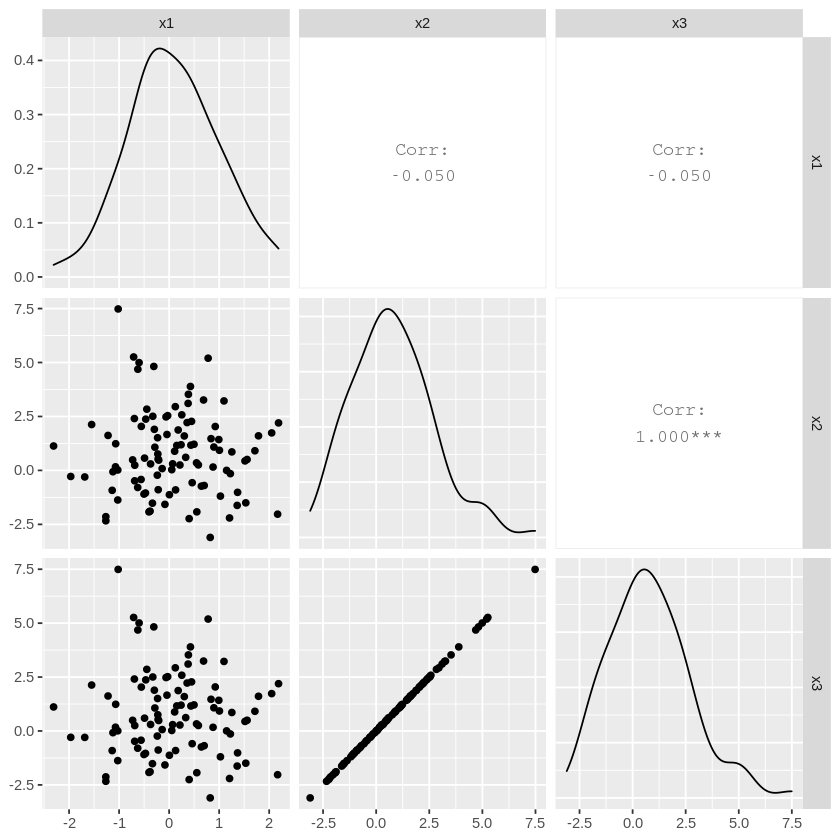

In [6]:
library(GGally)
ggpairs(df[,2:4])

Purtroppo, non tutti i problemi di questo tipo, detti problemi di *collinearità*, sono facilmente deducibili dal plot `ggpairs()` o dalla matrice delle correlazioni campionarie. Potrebbe infatti accadere che un predittore sia collineare a più predittori simultaneamente, ma non in modo così evidente con ognuno.
Questa situazione viene detta *multicollinearità*, ed è generata dalla collinearità di gruppi formati da più di due predittori.

## Variance inflation factor
Per poter mettere in luce problemi di multicollinearità, viene tipicamente utilizzato, per ogni predittore $j$, l'indice $\text{vif}_j$ (che sta per *variance inflation factor*), definito nel modo seguente

$$
\text{vif}_j = \frac{1}{1-R^2_{(-j)}}
$$

dove $R^2_{(-j)}$ rappresenta il valore del coefficiente di determinazione $R^2$ ottenuto costruendo un modello di regressione lineare, in cui il predittore $j$ funge da variabile di risposta, e le altre covariate da regressori. 
Il valore minimo del $\text{vif}_j$ è 1, e rappresenta il caso estremo in cui la variabile $j$ non è in alcun modo correlata alle altre covariate.
Purtroppo non abbiamo un valore critico specifico per il $\text{vif}_j$, che stabilisca assenza/presenza del problema di multicollinearità indotto dal predittore $j$. 
Una regola euristica può essere quella di rimuovere, dal modello di regressione lineare multipla, una alla volta, le covariate con $\text{vif}_j$ maggiore di 5 o 10 e quindi di ricalcolare i $\text{vif}_j$ ed iterare la procedura.
In `R` per calcolare il $\text{vif}_j$ di ogni predittore $j$, puoi usare la funzione `vif` del pacchetto `car`.

In [7]:
library(car)
mod <- lm(y ~ ., df)   
vif(mod) %>% round()

x1    x2    x3 
    1 34807 34807

Anche nel nostro esempio, essendo `x2` e `x3` fortemente correlate per definizione ($\text{vif}_j>10$).

In [8]:
#Rimuovi un predittore tra x2 e x3, per esempio x2 e ricalcola i vif.




# Metodi per la selezione del modello interpretativo migliore

Alla luce di questo aspetto e dei problemi evidenziati nella scorsa lezione, avrai intuito la necessità di individuare dei criteri di selezione del modello interpretativo migliore. 

## Variable selection

### Best subset selection attraverso `regsubsets()`

Consideriamo il data set dei giocatori di baseball, `Hitters` del pacchetto `ISLR`. L'obiettivo è cercare di prevedere lo stipendio dei giocatori (colonna `Salary`) sulla base delle loro caratteristiche, descritte dalle altre 19 colonne del dataset.

La funzione `regsubsets()` del pacchetto `leaps` trova automaticamente il migliore sottoinsieme di covariate. Fornisce il risultato per ogni numero di possibili covariate, cioè fornisce il miglior modello che includa una sola covariata, il miglior modello con due covariate,..., fino al modello con tutte le covariate (modello completo). 

In [9]:
library(ISLR)
names(Hitters)
dim(Hitters)
head(Hitters)

[1] "AtBat"     "Hits"      "HmRun"     "Runs"      "RBI"       "Walks"    
 [7] "Years"     "CAtBat"    "CHits"     "CHmRun"    "CRuns"     "CRBI"     
[13] "CWalks"    "League"    "Division"  "PutOuts"   "Assists"   "Errors"   
[19] "Salary"    "NewLeague"

[1] 322  20

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NA,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Conta il numero di giocatori per i quali nel dataset `Hitters` non è dichiarato il salario (`NA`).

In [10]:
sum(is.na(Hitters$Salary))

[1] 59

Costruisci quindi un dataset di lavoro `df` in cui non sono presenti tali giocatori e controlla le nuove dimensioni e che non ci siano ulteriori `NA` in altre colonne. 

In [11]:
df <- na.omit(Hitters)
dim(df)
sum(is.na(df))

[1] 263  20

[1] 0

Creiamo una scatterplot matrix delle variabili numeriche, ossia le colonne `1:13` e `16:19`. Non dare peso all'istruzione `upper = list(continuous = wrap("cor", size = 22))`. Serve unicamente a cambiare la grandezza dei caratteri della matrice di correlazione.

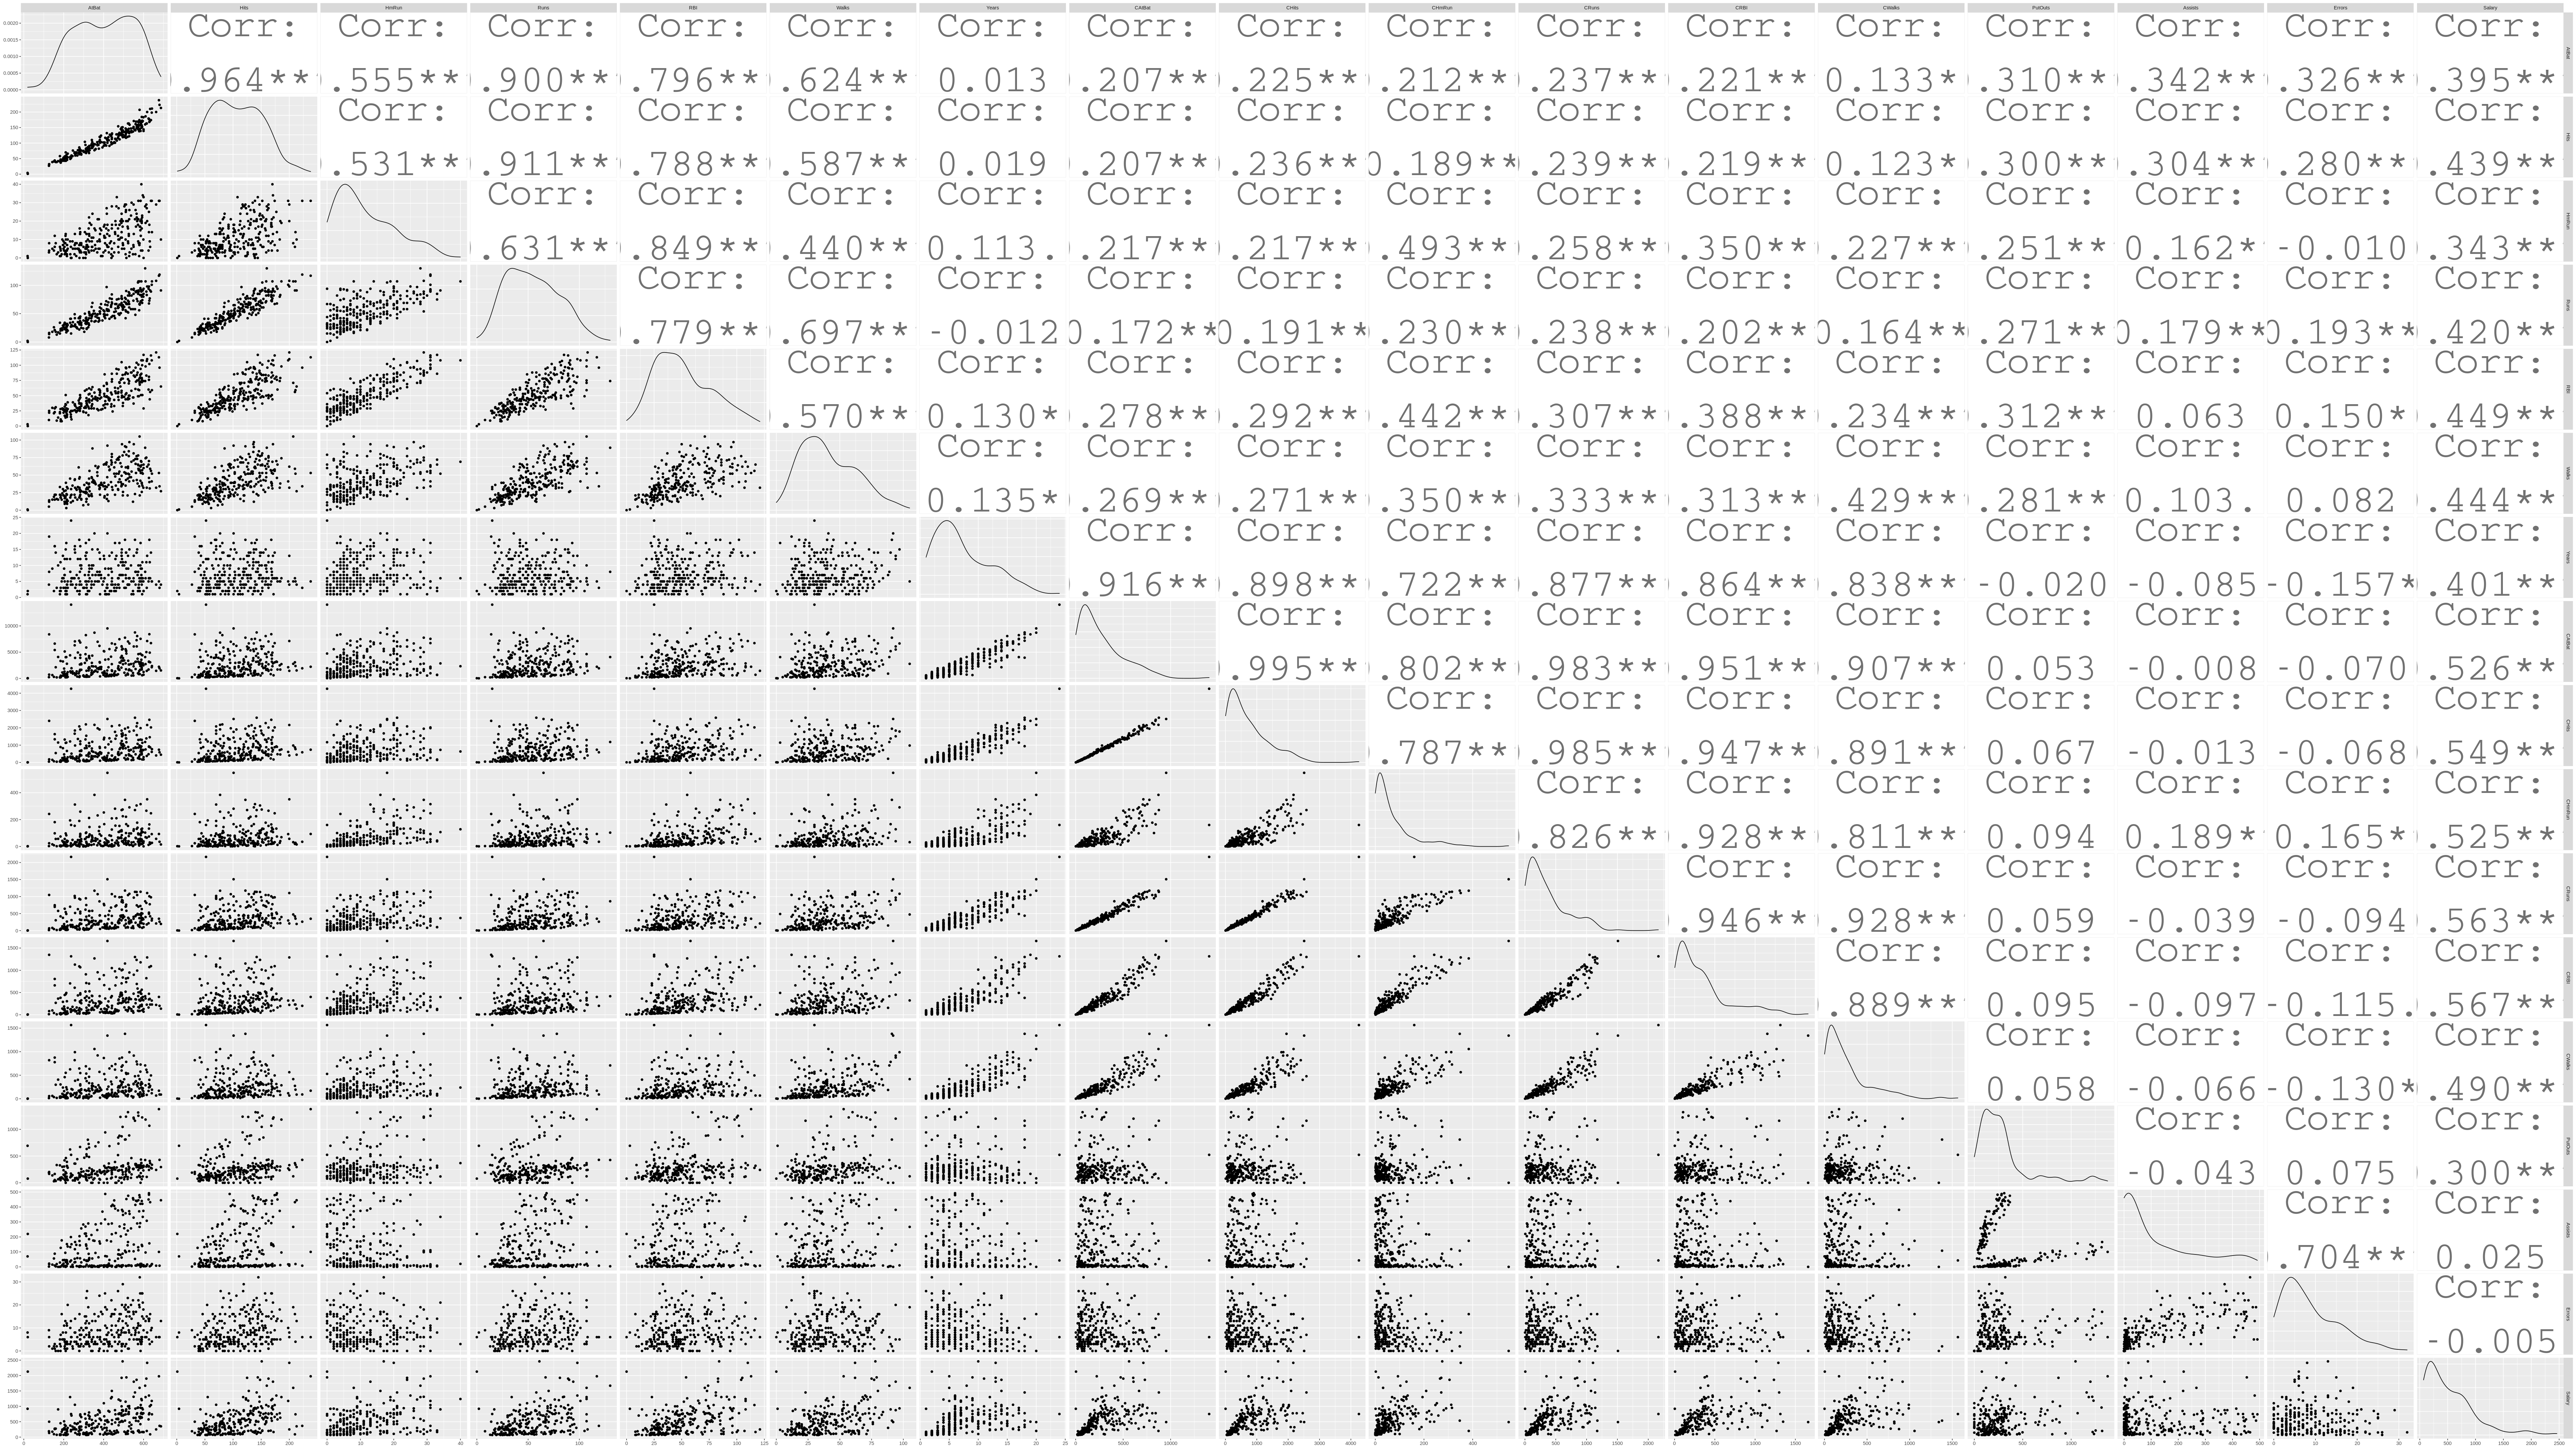

In [12]:
#consideriamo solamente variabili numeriche 
options(repr.plot.width=64, repr.plot.height=36) 
ggpairs(df[, c(1:13, 16:19)], upper = list(continuous = wrap("cor", size = 24)))

Ci accorgiamo che ci sono molte variabili fortemente correlate. 
Potrebbe essere utile aggiungere anche la visualizzazione della matrice di correlazione `cor(df[, c(1:13, 16:19)])` mediante la funzione `corrplot()` del pacchetto `corrplot`.

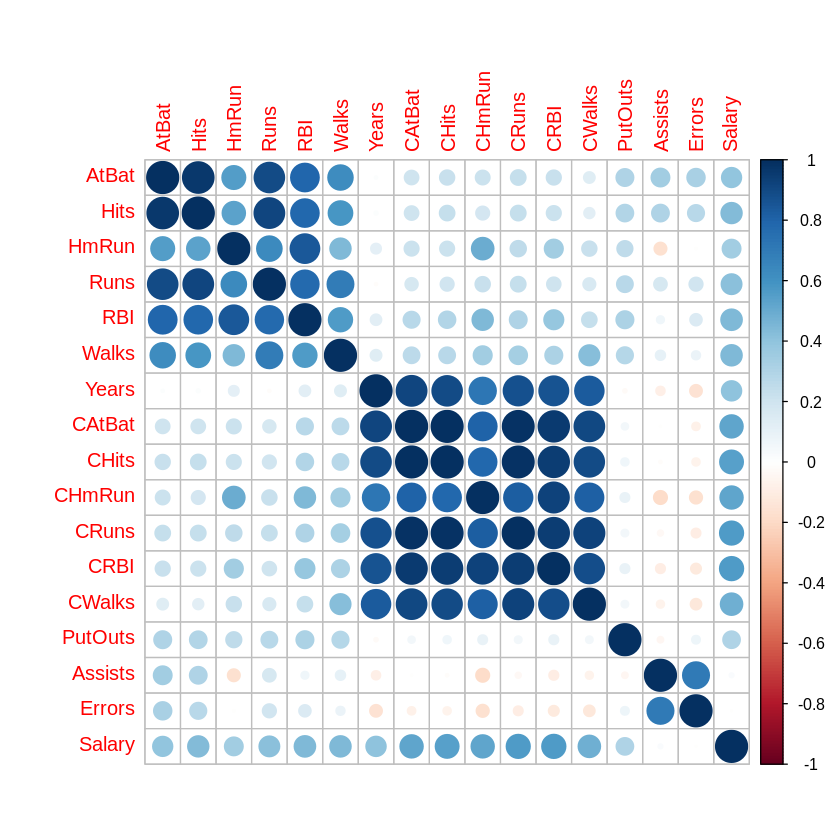

In [13]:
options(default)
library(corrplot)
corrplot(cor(df[, c(1:13, 16:19)]))

Attraverso la funzione `regsubsets(Salary~.,data=df, nvmax=19)` che 
* nel primo argomento specifica la variabile dipendente`Salary~.` 
* nel secondo`data=df` il dataset da utilizzare 
* e nel terzo `nvmax=19` il numero di variabili che al massimo vogliamo includere nel nostro modello

possiamo ottenere informazioni sulla scelta del modello interpretativo migliore e su quali siano le variabili da includere nel modello.

In [14]:
library(leaps) #funzione regsubsets
regfit.full <- regsubsets(Salary~.,data=df,nvmax=19) #nvmax è 8 di default
reg.summary <- summary(regfit.full)

Nella variabile `regfit.full` abbiamo registrato l'output di `regsubsets()`. Tuttavia questo output non è quasi mai di pratica utilità, e deve essere necessariamente dato in input alla funzione `summary()` per la scelta del modello interpretativo migliore. 
La variabile `reg.summary` in cui abbiamo registrato l'output di `summary(regfit.full)` contiene le seguenti informazioni

In [15]:
names(reg.summary)

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

L'informazione più importante, e su cui ti invito a riflettere, è il coefficiente di determinazione contenuto in `$rsq`

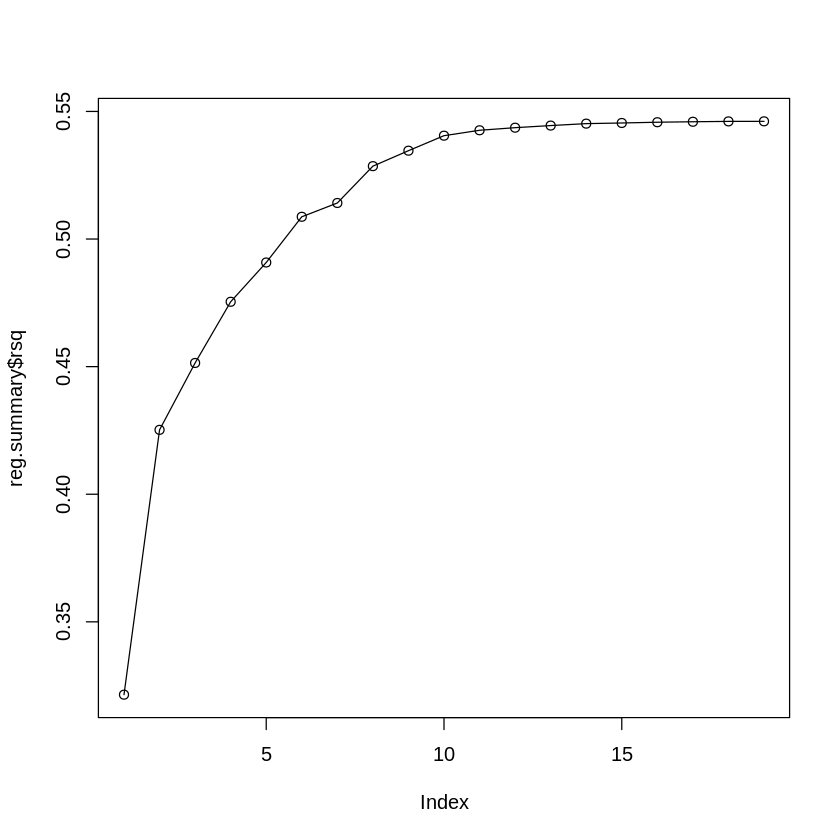

In [16]:
options(default)
plot(reg.summary$rsq, type = "l")
points(reg.summary$rsq)

## Scelta tra i modelli basata sull'errore di previsione *in-sample*

Osserva che il coefficiente di determinazione `multiple R-squared` non diminuisce con il numero di covariate, in quanto non dipende dal numero di covariate incluse nel modello.
Si può affermare che un modello selezionato tramite la massimizzazione del coefficiente di determinazione `multiple R-squared` tende a selezionare modelli che si adattano troppo ai dati sperimentali del training set.
Per tale motivo, non può essere utilizzato come criterio per individuare il modello interpretativo migliore, in quanto sceglierebbe sempre il modello completo. E il criterio del "gomito", introdotto già nello scree plot della PCA, potrebbe non essere di grande utilità. 

Un modello che si adatta troppo bene ai dati sperimentali, che sembrerebbe a prima vista un modello perfetto dal punto di vista della capacità descrittiva del data set sperimentale, genera tuttavia il cosiddetto problema di *overfitting* (o *undersmoothing*). Un modello che soffre del problema di overfitting viene anche detto troppo *flessibile*, ed è probabilmente incapace di prevedere il valore della variabile di risposta in corrispondenza di osservazioni che non facevano parte del training set. Per esempio immagina di avere soli due punti sperimentali (non coincidenti) e di utilizzare un modello di regressione semplice per la predizione numerica. Tale modello, qualsiasi siano i valori delle variabili dipendenti e indipendenti avrà un `multiple R-squared` pari a 1, dovuto al fatto che il numero di parametri $p+1=2$ è pari alla numerosità campionaria ($n=2$), o dal punto di vista matematico, che due punti sono per definizione allineati. Il modello prevede che qualsiasi altro punto sperimentale futuro sia allineato a quelli su cui è stato stimato il modello. 

Quanto ti fidi di una previsione proveniente da tale modello? 

Questo semplice controesempio può essere generalizzato al caso di un modello di regressione con $p=2$ predittori, stimato su $n=3$ punti sperimentali. Più in generale, questo controesempio può essere esteso al caso della stima (chiamata spesso in senso lato addestramento o apprendimento) di un modello iperflessibile, con un elevatissimo numero di parametri (come vedrai nel caso delle *deep neural network*), basata su un numero di dati sperimentali, che potrebbe sembrare elevato in assoluto, ma che non lo è rispetto al numero di parametri (a volte non facilmente esplicitabile) del modello.

Per ovviare al problema dell'overfitting, se la **numerosità** del campione è sufficientemente **elevata** da permetterlo, si preferisce tenere separato dal training sample (a volte anche chiamato *training set* o *train set*) un numero di osservazioni $n_{\text{test}}$ a formare quello che viene chiamato *test set*. Il test set viene utilizzato per calcolare gli errori di previsione, anche chiamati, in questo contesto, errori di previsione *out-of-sample*. Tali errori rappresentano gli scostamenti della previsione da valori (che finora abbiamo chiamato valori futuri) che, per costruzione, non sono contenuti nel training set. Il training set viene utilizzato per stimare i coefficienti di regressione (ossia il modello). Il test set viene utilizzato per calcolare quanto il modello sia in grado di prevedere nuovi valori della variabile dipendente sulla base dei valori assunti dalle variabili indipendenti (predittori).

Se la **numerosità** del campione invece è **bassa**, per stimare la capacità previsionale del modello non si può fare altro che utilizzare i residui, o errori di previsione *in-sample*, facendo attenzione a considerare come varianza dell'errore *in sample* quella che utilizzeresti per costruire gli intervalli di previsione (e non $\sigma^2_{\varepsilon}$). Utilizzando gli errori in-sample verrano scelti modelli più flessibili ma, in generale, con una più bassa abilità predittiva. 

In caso di numerosità bassa, quando la divisione in training e test set non è possibile, vengono quindi utilizzati differenti criteri di scelta. Tutti questi criteri sono quindi basati sui dati utilizzati per stimare il modello e pertanto sulla stima dell'errore di previsione in-sample. Il primo di questi criteri lo conosci già.

### $R^2$ corretto `adjusted R-squared`

Nel video "Regressione lineare semplice - Interpretazione grafica", e nel reading sulla regressione lineare multipla avevamo introdotto il coefficiente di determinazione corretto `adjusted R-squared`. In generale tale coefficiente è definito come

$$R^2_{adjusted}=\frac{\frac{\sum_{i=1}^n(y_i-\hat y_i)^2}{n-p-1}}{\frac{\sum_{i=1}^n(y_i-\bar y)^2}{n-1}}=\frac{n-1}{n-p-1}\frac{\sum_{i=1}^n(y_i-\hat y_i)^2}{\sum_{i=1}^n(y_i-\bar y)^2}$$

che, rispetto al coefficiente di determinazione $R^2$ penalizza modelli con un numero alto di predittori $p$. Si può infatti dimostrare che 

$$R^2_{adj} = 1 - (1 - R^2) \frac{n - 1}{n - p - 1}.$$

A parità di $R^2$, quindi $R^2_{adj}$ diminuisce  all'aumentare del numero $p$ di regressori. 
Si preferisce, come sappiamo, un modello con $R^2_{adj}$ più alto.

### Criterio d'informazione di Akaike

Il criterio d'informazione di Akaike,indicato con $AIC$ o $C_p$, è definito come
$$AIC = -2 l + 2 p$$ 
dove $l$ è un valore che è tanto più alto quanto più il modello si adatta ai dati. Il criterio d'informazione di Akaike tipicamente diminuisce all'aumentare della somma dei residui al quadrato, come $R^2$, ma è penalizzato dal termine $2p$. Si preferisce il modello con $AIC$ più basso.

### Criterio d'informazione di Bayes ($BIC$)
$$BIC = -2 l + p\ \log N$$
dove $N$ è la dimensione del campione. 
Come per l'$AIC$, si preferisce il modello con il $BIC$ più basso. Il $BIC$ per ampiezze campionarie elevate ($N$ grande) tende a preferire/selezionare  modelli più parsimoniosi (con un numero minore di predittori) rispetto all'AIC.

Applichiamo quanto detto al data set `Hitters`.

[1] 11

[1] 10

[1] 6

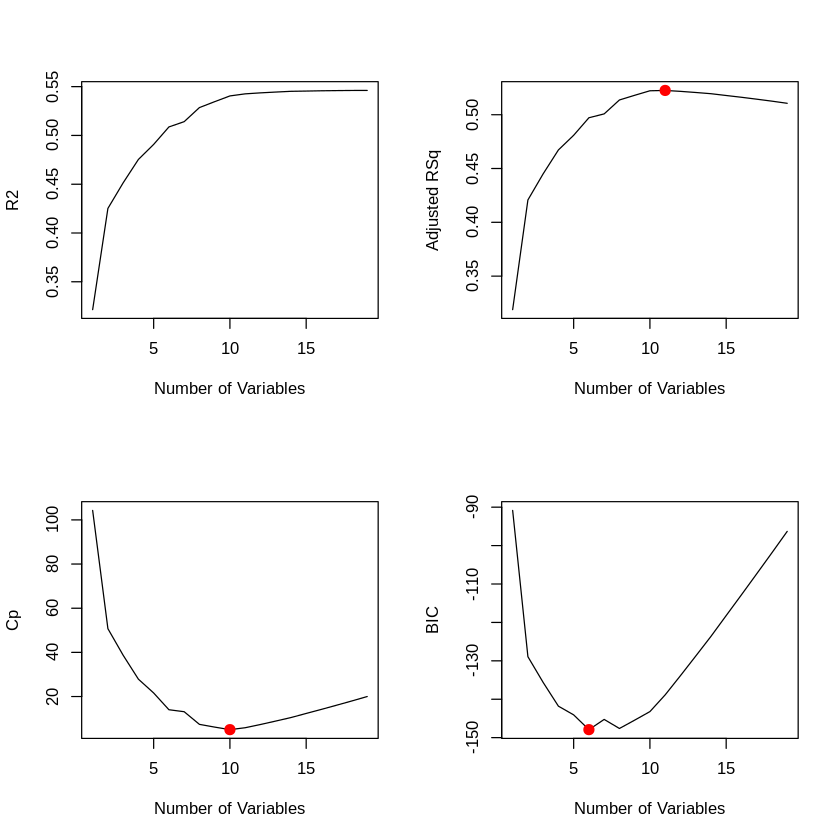

In [17]:
par(mfrow=c(2,2))
plot(reg.summary$rsq, xlab="Number of Variables",ylab="R2", type = "l")
plot(reg.summary$adjr2,xlab="Number of Variables",ylab="Adjusted RSq",type="l")
which.max(reg.summary$adjr2)
points(11,reg.summary$adjr2[11], col="red",cex=2,pch=20)
plot(reg.summary$cp,xlab="Number of Variables",ylab="Cp",type='l')
which.min(reg.summary$cp)
points(10,reg.summary$cp[10],col="red",cex=2,pch=20)
which.min(reg.summary$bic)
plot(reg.summary$bic,xlab="Number of Variables",ylab="BIC",type='l')
points(6,reg.summary$bic[6],col="red",cex=2,pch=20)

I diversi criteri selezionano, basandosi sull'oggetto `reg.summary`, un diverso modello interpretativo. Tipicamente si tende a selezionare quello più parsimonioso, sia per ragioni computazionali sia perché un numero minore di covariate è di norma più interpretabile. 

Per ottenere i coefficienti di regressione basta utilizzare la funzione `coef()` all'oggetto `regfit.full`

In [18]:
coef(regfit.full,6) %>% round(2)

(Intercept)       AtBat        Hits       Walks        CRBI   DivisionW 
      91.51       -1.87        7.60        3.70        0.64     -122.95 
    PutOuts 
       0.26

Ossia, il modello interpretatvo migliore è il seguente $$ y= 91.51-1.87 x_1+7.6 x_2+3.7 x_3+0.64 x_4-122.95 x_5 + 0.26 x_6$$

## Selezione stepwise: Forward e Backward 
La scelta del modello interpretativo migliore mediante la funzione `regsubsets()` che esplora tutte le possibili combinazioni di modelli ad un numero crescente di covariate può risultare particolarmente onerosa nel caso in cui il numero di covariate è particolarmente alto. Pertanto esistono due versioni euristiche dell'algoritmo di *best subset selection* meno onerose dal punto di vista computazionale, ma in grado di individuare comunque una soluzione, tipicamente soddisfacente, ma non necessariamente coincidente con quella individuata da `regsubsets()`, che individua chiaramente il modello migliore. 

Tali versioni euristiche dell'algoritmo vengono denominate *forward selection* o *backward elimination*, e vengono ottenute aggiungendo l'argomento `method="forward"` o `method="backward"` a `regsubsets()`.

Il primo parte dal modello con una sola covariata, e aggiunge via via ad ogni passo il predittore che incrementa di più il valore di $R^2$, fino ad arrivare al modello completo.

In [19]:
regfit.fwd <- regsubsets(Salary~.,data=df,nvmax=19,method="forward")
reg.summary.fwd <- summary(regfit.fwd)

Possiamo vedere l'andamento dell'algoritmo visualizzando la matrice `$outmat` dell'output `reg.summary.fwd`.


In [20]:
reg.summary.fwd$outmat

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,LeagueN,DivisionW,PutOuts,Assists,Errors,NewLeagueN
1 ( 1 ),,,,,,,,,,,,*,,,,,,,
2 ( 1 ),,*,,,,,,,,,,*,,,,,,,
3 ( 1 ),,*,,,,,,,,,,*,,,,*,,,
4 ( 1 ),,*,,,,,,,,,,*,,,*,*,,,
5 ( 1 ),*,*,,,,,,,,,,*,,,*,*,,,
6 ( 1 ),*,*,,,,*,,,,,,*,,,*,*,,,
7 ( 1 ),*,*,,,,*,,,,,,*,*,,*,*,,,
8 ( 1 ),*,*,,,,*,,,,,*,*,*,,*,*,,,
9 ( 1 ),*,*,,,,*,,*,,,*,*,*,,*,*,,,
10 ( 1 ),*,*,,,,*,,*,,,*,*,*,,*,*,*,,


Il secondo parte dal modello completo, ed elimina, ad ogni passo, la covariata che decrementa di meno il valore di $R^2$.

In [21]:
regfit.bwd <- regsubsets(Salary~., data=df,nvmax=19, method="backward")
reg.summary.bwd <- summary(regfit.bwd)

Possiamo vedere l'andamento dell'algoritmo visualizzando la matrice `$outmat` dell'output `reg.summary.bwd`. Di default, la matrice viene visualizzata mostrando nella prima riga il modello migliore con una variabile, nella seconda riga il modello migliore con due variabili e così via, come nella selezione forward stepwise. 

D'altra parte, risulta più utile invertire l'ordine delle righe della matrice per mettere in evidenza, dall'alto verso il basso, gli step successivi dell'algoritmo.


In [22]:
reg.summary.fwd$outmat[rev(1:nrow(reg.summary.fwd$outmat)), ]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,LeagueN,DivisionW,PutOuts,Assists,Errors,NewLeagueN
19 ( 1 ),*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
18 ( 1 ),*,*,*,*,*,*,*,*,*,,*,*,*,*,*,*,*,*,*
17 ( 1 ),*,*,*,*,*,*,,*,*,,*,*,*,*,*,*,*,*,*
16 ( 1 ),*,*,*,*,*,*,,*,*,,*,*,*,*,*,*,*,*,
15 ( 1 ),*,*,*,*,,*,,*,*,,*,*,*,*,*,*,*,*,
14 ( 1 ),*,*,*,*,,*,,*,,,*,*,*,*,*,*,*,*,
13 ( 1 ),*,*,,*,,*,,*,,,*,*,*,*,*,*,*,*,
12 ( 1 ),*,*,,*,,*,,*,,,*,*,*,*,*,*,*,,
11 ( 1 ),*,*,,,,*,,*,,,*,*,*,*,*,*,*,,
10 ( 1 ),*,*,,,,*,,*,,,*,*,*,,*,*,*,,


Osserva che i tre metodi selezionano, ad ogni fissato numero di covariate, un sottinsieme diverso.

In [23]:
coef(regfit.full,7) %>% round(2)
coef(regfit.fwd,7) %>% round(2)
coef(regfit.bwd,7) %>% round(2)

(Intercept)        Hits       Walks      CAtBat       CHits      CHmRun 
      79.45        1.28        3.23       -0.38        1.50        1.44 
  DivisionW     PutOuts 
    -129.99        0.24

(Intercept)       AtBat        Hits       Walks        CRBI      CWalks 
     109.79       -1.96        7.45        4.91        0.85       -0.31 
  DivisionW     PutOuts 
    -127.12        0.25

(Intercept)       AtBat        Hits       Walks       CRuns      CWalks 
     105.65       -1.98        6.76        6.06        1.13       -0.72 
  DivisionW     PutOuts 
    -116.17        0.30

Come ci aspettavamo, le versioni forward selection (linee in rosso) e backward elimination (linee verdi) raggiungono valori di $R^2$, $R^2_{adj}$, AIC e BIC, sub-ottimi. 

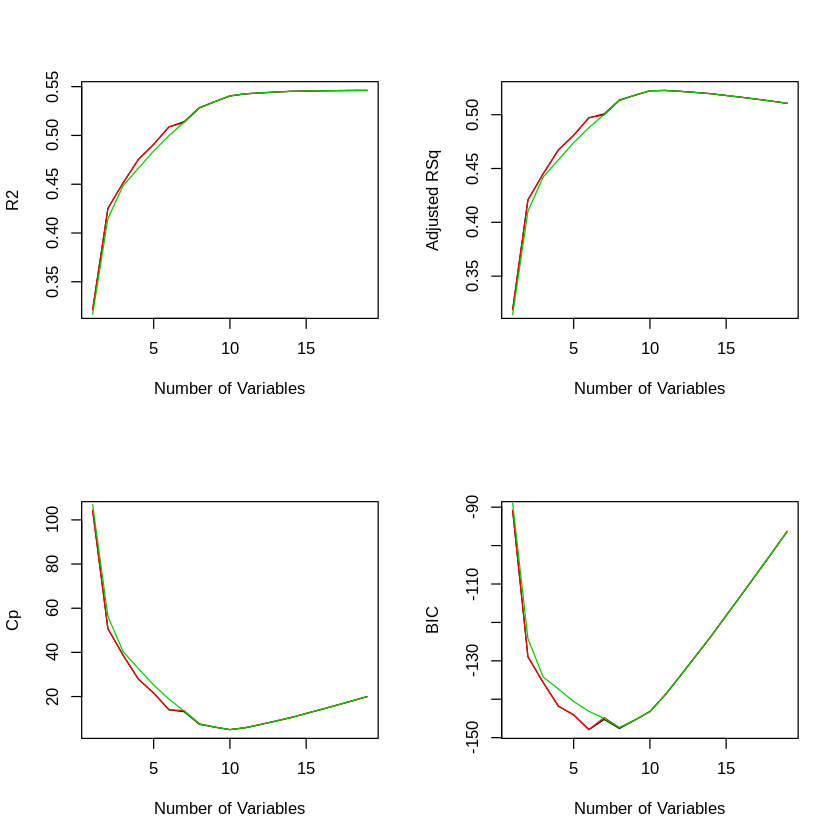

In [24]:
par(mfrow=c(2,2))
plot(reg.summary$rsq, xlab="Number of Variables",ylab="R2", type = "l")
lines(reg.summary.fwd$rsq, xlab="Number of Variables",ylab="R2", type = "l", col=2)
lines(reg.summary.bwd$rsq, xlab="Number of Variables",ylab="R2", type = "l", col=3)

plot(reg.summary$adjr2, xlab="Number of Variables",ylab="Adjusted RSq",type="l")
lines(reg.summary.fwd$adjr2, xlab="Number of Variables",ylab="R2", type = "l", col=2)
lines(reg.summary.bwd$adjr2, xlab="Number of Variables",ylab="R2", type = "l", col=3)

plot(reg.summary$cp, xlab="Number of Variables",ylab="Cp",type='l')
lines(reg.summary.fwd$cp, xlab="Number of Variables",ylab="R2", type = "l", col=2)
lines(reg.summary.bwd$cp, xlab="Number of Variables",ylab="R2", type = "l", col=3)

plot(reg.summary$bic,xlab="Number of Variables",ylab="BIC",type='l')
lines(reg.summary.fwd$bic, xlab="Number of Variables",ylab="R2", type = "l", col=2)
lines(reg.summary.bwd$bic, xlab="Number of Variables",ylab="R2", type = "l", col=3)

## Scelta tra i modelli basata sull'errore di previsione *out-of-sample*

Come anticipato, gli indici visti finora misurano quanto il modello sia in grado di adattarsi al training set, sulla base del cosiddetto errore in-sample. Tuttavia, nonostante i criteri introdotti cerchino di selezionare il modello più parsimonioso, penalizzando un alto numero di variabili, così come costruiti, non sono in grado di misurare quanto il modello stimato sia in grado di adattarsi a casi/valori futuri, ossia dati non utilizzati per la stima del modello.

Se avessi a disposizione (o conservassi dall'inizio) un test set, potresti calcolare, su tale insieme di dati, l'errore quadratico medio (MSE) che rappresenta una stima dell'errore di previsione *out-of-sample*. In particolare, per ogni modello ottenuto con `regsubsets()`, per un diverso numero di covariate, otterresti un diverso MSE. Si seleziona il modello con MSE più basso.

Puoi, in caso di alta numerosità campionaria, dividere il data set a caso (attraverso la funzione `sample()`) per esempio in due parti uguali, come nel blocco di codice seguente, in cui viene generato 
* un training set `dftrain` e 
* un test set `dftest`, entrambi con un numero di righe pari a `nrow(df) / 2`. 

Quindi, puoi applicare `regsubsets()` al solo `dftrain`, ottenendo `regfit.best`.

In [25]:
set.seed(1)
train <- sample(1:nrow(df), size = nrow(df) / 2)
dftrain <- df[train, ]
dftest <- df[-train, ]
regfit.best <- regsubsets(Salary ~ . , data = dftrain, nvmax = 19)

Il codice seguente calcola
* `val.errors`, 
che contiene l'*errore out-of-sample*, ossia la media dell'errore di previsione al quadrato rispetto al valore vero della y (`Salary`) per tutti i modelli contenuti in `regfit.best`
* `coef(regfit.best)`, che contiene i valori dei coefficienti dei modelli di regressione contenuti in `regfit.best`
* il grafico della stima dell'errore *out-of-sample*.

Sfortunatamente, non c'è una funzione analoga a `predict()` per un'istruzione del tipo `regsubset()`. Quindi **non** è possibile scrivere un'istruzione del tipo` predict(regfit.best, dftest)`, come di solito si fa con i modelli ottenuti tramite `lm()`, per ottenere una previsione del valore della y (nel nostro caso il salario) in corrispondenza delle covariate contenute nel data set `dftest`.
Quindi, a questo scopo, nel codice che segue, è stato necessario definire la funzione `predict.regsubsets()`, che, nello stile di `predict()`, accetta gli argomenti:
* `object`, i modelli ottimali stimati mediante `regsubsets(dftrain)` per un numero di covariate che va da 1:nvmax (nel nostro esempio `nvmax=19`)
* `newdata`, il test set
* `id`, l'indice che permette di selezionare il miglior modello ad un numero crescente di covariate

In tal modo, la funzione potrà essere richiamata mediante l'istruzione `predict.regsubsets(mod, newdata, id)`. Per le finalità didattiche di questo corso, i dettagli per la definizione di tale funzione possono essere omessi.

[1] 186716.3 162285.2 151838.5 153123.6 149526.5 144196.0 145793.0 151964.3
 [9] 156090.9 158975.0 161495.8 161019.2 157633.1 157508.2 162951.4 163352.4
[17] 166805.0 166986.7 168593.3

(Intercept)       Walks      CAtBat       CHits      CHmRun   DivisionW 
     181.70        4.25       -0.53        2.05        2.46     -131.17 
    PutOuts 
       0.18

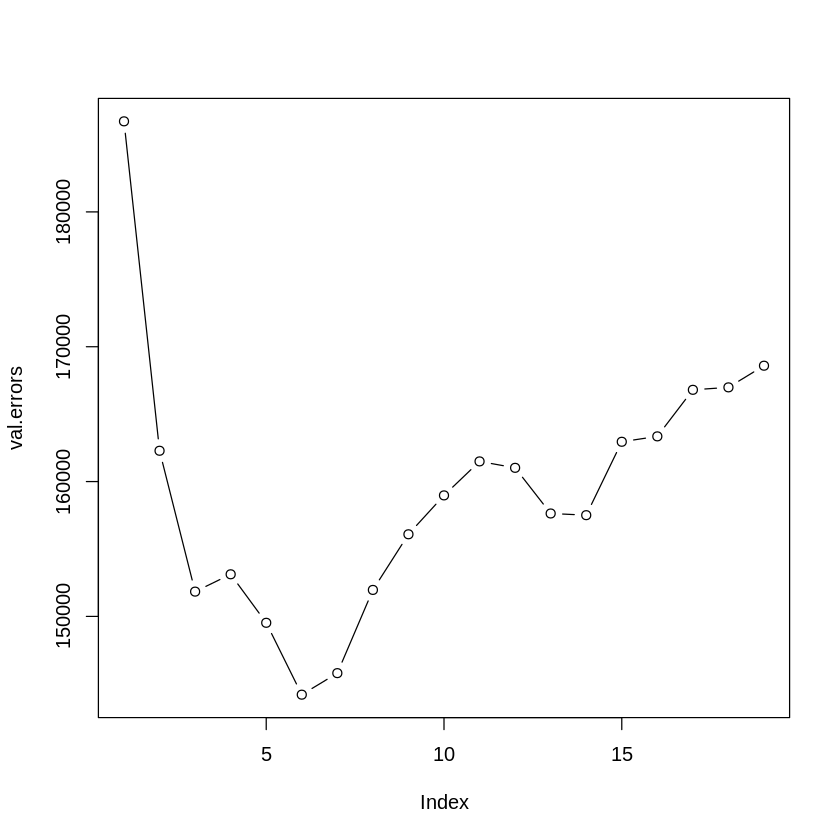

In [26]:
#possono essere omessi i dettagli per la definizione della seguente funzione
predict.regsubsets <- function(object,newdata,id,...){
  form <- as.formula(object$call[[2]])
  mat <- model.matrix(form,newdata)
  coefi <- coef(object,id=id)
  xvars <- names(coefi)
  mat[,xvars]%*%coefi
}

val.errors <- rep(NA,19)
for(i in 1:19){
   pred <- predict.regsubsets(regfit.best, newdata = dftest, id = i)
   val.errors[i] <- mean((dftest$Salary-pred)^2)
}

val.errors  %>% round(2)
plot(val.errors, type='b')
coef(regfit.best,which.min(val.errors)) %>% round(2)

Il modello con le 6 covariate elencate è il modello che minimizza l'errore (quadratico medio) out-of-sample. Ovviamente, questo risultato potrebbe variare se partissimo da una diversa divisione in training e test set:
* in termini di percentuale di numero di righe assegnate al training e test set (in questo caso ricorda che sono state divise alla pari in training e test set) 
*  in termini di righe/osservazioni incluse nel training set e nel test set, a fissata percentuale.

Per ottenere un risultato che risenta meno di questi aspetti, puoi automatizzare questo ragionamento e ricorrere ad uno schema chiamato 

## $k$-fold cross-validation (validazione incrociata)

La validazione incrociata prevede, per ogni modello, la stima dell'errore di previsione nei passi seguenti

1. Partiziona il data set in $k$ gruppi (fold). 
2. Rimuovi dal data set il gruppo $j=1$ e usalo come test set.
3. Usa i rimanenti $k-1$ gruppi (che non includono più le osservazioni dal gruppo $j$) come training set.
4. Costruisci il modello usando il training set e usalo per prevedere la variabile di risposta per le osservazioni nel test set e  salva gli errori di previsione.
5. Ripeti i passi 3. e 4. per $j=2,\ldots,k$.
6. La media degli errori di previsione al quadrato salvati per  $j=1,\ldots,k$ rappresenta il MSE. 

La quantità MSE viene usata per confrontare il modello considerato con gli altri modelli contenenti un numero diverso di covariate e contenuti nell'output di `regsubsets()`. 

A tal fine, puoi fare un doppio loop: uno  sui differenti modelli e l'altro sui $k$ gruppi usati come test set. Di seguito, viene implementato il doppio loop nel caso tipico in cui $k$ viene fissato pari a 10.
$k=10$ è una scelta tipicamente utilizzata quando si hanno molte osservazioni. Un'altra scelta molto comune, soprattutto quando si hanno poche osservazioni a disposizione, è $k=1$. In tal caso si parlerà di *leave-one-out cross-validation*.

[1] 149821 130922 139127 131029 131050 119539 124286 113580 115556 112217
[11] 113251 115756 117821 119481 120122 120074 120085 120086 120404

(Intercept)       AtBat        Hits       Walks      CAtBat       CRuns 
     162.54       -2.17        6.92        5.77       -0.13        1.41 
       CRBI      CWalks   DivisionW     PutOuts     Assists 
       0.77       -0.83     -112.38        0.30        0.28

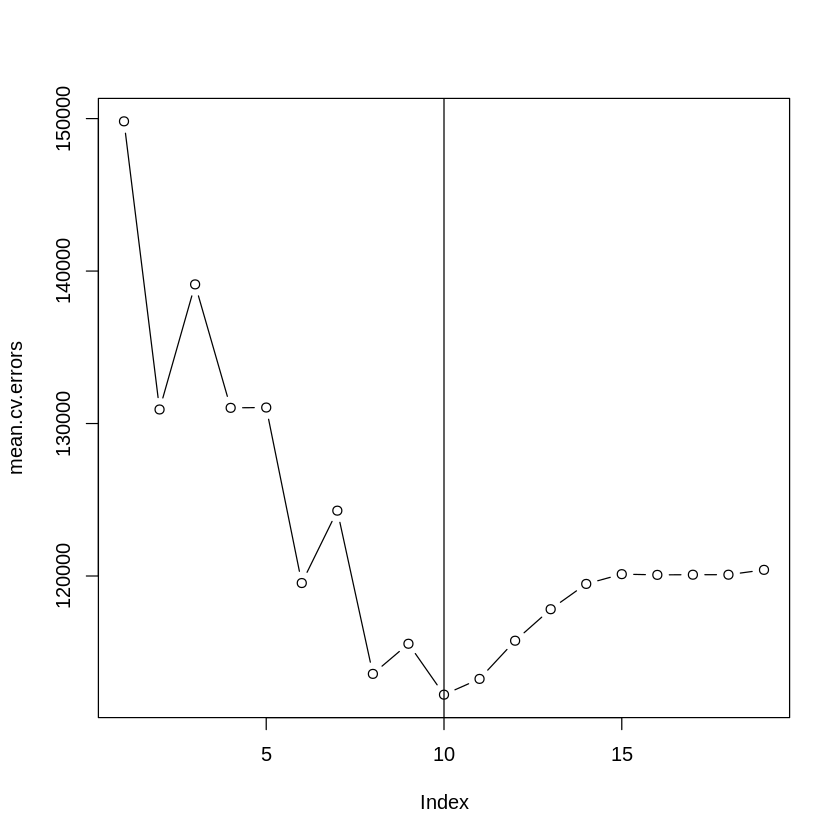

In [27]:
set.seed(1)
k <- 10 #10-fold cross-validation
folds <- sample(1:k, nrow(df), replace=TRUE)
cv.errors <- matrix(NA, nrow = k, ncol = 19)
#ciclo su ciascun gruppo di osservazioni
for(j in 1:k){
  best.fit <- regsubsets(Salary~.,data=df[folds!=j,],nvmax=19)
  #ciclo sui differenti modelli
  for(i in 1:19){
    pred <- predict(best.fit, df[folds==j,], id=i)
    cv.errors[j,i] <- mean( (df$Salary[folds==j]-pred)^2)
    }
  }
mean.cv.errors <- colMeans(cv.errors); mean.cv.errors  %>% round()
p_opt <- which.min(mean.cv.errors)
par(mfrow=c(1,1))
plot(mean.cv.errors,type='b')
abline(v = p_opt)
reg.best <- regsubsets(Salary~.,data=df, nvmax=19)
coef(reg.best, p_opt)  %>% round(2)

I risultati si commentano facilmente. Il valore minimo del MSE si ottiene in corrispondenza di 10 covariate, che risulta essere il modello con il potere predittivo maggiore.

Complimenti! Se sei arrivato a questo punto, sei pronto per l'ultima unità, riguardante i rimedi più moderni per mitigare l'impatto della multicollinearità sulla stima del modello attraverso il metodo dei minimi quadrati.